In [1]:
import glob
import pandas as pd
import pybedtools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools

In [2]:
group_name = 'DG_Glut'

In [3]:
ct = group_name
res = 25000
ddir = f'/data/female-amb/Diff.Result/CellType.Age.Diff.Domain/{ct}'
_dir = '/home/qzeng_salk_edu/project'
_min = 2e-308

In [4]:
binall = pd.read_csv(f'{_dir}/binall.csv',  index_col =0)
binall.columns = ['chrom', 'start','end']

In [5]:
all_diff_domain = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/ALL.Diff.Domain.csv', index_col = 0)
ct_diff_domain = all_diff_domain[all_diff_domain['celltype'] == ct]
ct_diff_domain =  ct_diff_domain[(ct_diff_domain['18mo-8wk'] > 0.05)]
ct_diff_domain = pd.concat([ct_diff_domain, binall], axis = 1).dropna()
ct_diff_domain = ct_diff_domain[[ 'chrom', 'start', 'end','8wk', '9mo', '18mo', '18mo-8wk', 'celltype']]
ct_diff_domain.head()

,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
chr1_381,chr1,9525000,9550000,0.111111,0.125786,0.162823,0.051712,DG_Glut
chr1_686,chr1,17150000,17175000,0.153739,0.165618,0.241090,0.087352,DG_Glut
chr1_1020,chr1,25500000,25525000,0.092942,0.098532,0.144654,0.051712,DG_Glut
chr1_1034,chr1,25850000,25875000,0.120196,0.122292,0.197065,0.076869,DG_Glut
chr1_1346,chr1,33650000,33675000,0.145353,0.139064,0.201957,0.056604,DG_Glut


In [6]:
print(f"{ct_diff_domain.shape[0]} diff domain boundary")

494 diff domain boundary


## get boundary genes

In [7]:
leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
ddir = f'/data/female-amb/Diff.Result/hicluster_bulk_domain/'

In [8]:
# bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
# cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
# bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
# bound_prob_ct= bound_prob_ct.T
# bound_prob_ct.head()

## inersect with gene

In [9]:
ct_diff_domain = ct_diff_domain[['chrom', 'start', 'end','8wk', '9mo', '18mo', '18mo-8wk', 'celltype' ]]

In [10]:
genes = pd.read_csv('/home/qzeng_salk_edu/project/240424_domain_gene/mm10.gene.bed', sep = '\t', header = None)
genes.columns = ['gene_chr','gene_start','gene_end','gene_name','strand','gene_type', 'gene_length']
genes.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length
0,chr1,3073253,3074322,4933401J01Rik,+,TEC,1069
1,chr1,3102016,3102125,Gm26206,+,snRNA,109
2,chr1,3205901,3671498,Xkr4,-,protein_coding,465597
3,chr1,3252757,3253236,Gm18956,+,processed_pseudogene,479
4,chr1,3365731,3368549,Gm37180,-,TEC,2818


In [11]:
genes_bed = pybedtools.BedTool.from_dataframe(genes)
ct_diff_domain_bed = pybedtools.BedTool.from_dataframe(ct_diff_domain)
# Find overlaps
overlaps = genes_bed.intersect(ct_diff_domain_bed, wa=True, wb=True, f =0.9)
overlaps_df = overlaps.to_dataframe(names = genes.columns.tolist() + ct_diff_domain.columns.tolist())
overlaps_df.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length,chrom,start,end,8wk,9mo,18mo,18mo-8wk,celltype
0,chr1,9545408,9547455,Rrs1,+,protein_coding,2047,chr1,9525000,9550000,0.111111,0.125786,0.162823,0.051712,DG_Glut
1,chr1,17168403,17173103,Gm28784,+,lncRNA,4700,chr1,17150000,17175000,0.153739,0.165618,0.241090,0.087352,DG_Glut
2,chr1,33657781,33658108,Gm17813,+,processed_pseudogene,327,chr1,33650000,33675000,0.145353,0.139064,0.201957,0.056604,DG_Glut
3,chr1,33669824,33670712,1700001G17Rik,+,TEC,888,chr1,33650000,33675000,0.145353,0.139064,0.201957,0.056604,DG_Glut
4,chr1,33671915,33674228,Gm38173,-,TEC,2313,chr1,33650000,33675000,0.145353,0.139064,0.201957,0.056604,DG_Glut


In [12]:
print(f"{overlaps_df.shape[0]} genes overlap with the TAD boundary")

213 genes overlap with the TAD boundary


In [13]:
overlaps_df.to_csv('All.Overlap.Boundary.Genes.csv')

In [14]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
use_genes = expr[expr.sum(axis = 1) > 0.1].index
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [15]:
all_gene_result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
all_gene_result['log2(18mo/2mo)'] = np.log2(all_gene_result['fc']) 
all_gene_result['-log10(padj)'] = -np.log10(all_gene_result['fdr'] + _min)
all_gene_result =all_gene_result[all_gene_result['fdr'] != 1]
all_gene_result = all_gene_result[~all_gene_result.index.str.startswith('Gm')]
deg_result = all_gene_result[(all_gene_result['fdr'] < 0.01) & (abs(all_gene_result['log2(18mo/2mo)']) > 0.1)]

In [16]:
#all_gene_result = all_gene_result.loc[all_gene_result.index.isin(overlaps_df['gene_name'].values)]

In [17]:
overlap_deg_result = deg_result.loc[deg_result.index.isin(overlaps_df['gene_name'].values)]
overlap_deg_result['gene_length'] = overlap_deg_result.index.map(overlaps_df.set_index('gene_name')['gene_length'].to_dict())
overlap_deg_result['abs_log2(18mo/2mo)'] = abs(overlap_deg_result['log2(18mo/2mo)'])
overlap_deg_result.sort_values('fdr').head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo)
gene,,,,,,
Tmem59,0.790906,1.081476e-15,-0.338422,14.965983,22597,0.338422
Rnasek,0.503707,1.941939e-15,-0.989344,14.711764,1718,0.989344
Rps23,0.413663,1.848198e-12,-1.273473,11.733251,1992,1.273473
Jkamp,0.721120,5.267675e-08,-0.471689,7.278381,15872,0.471689
Gtpbp8,0.773520,4.286767e-07,-0.370490,6.367870,9595,0.370490


[(-3.0, 3.0)]

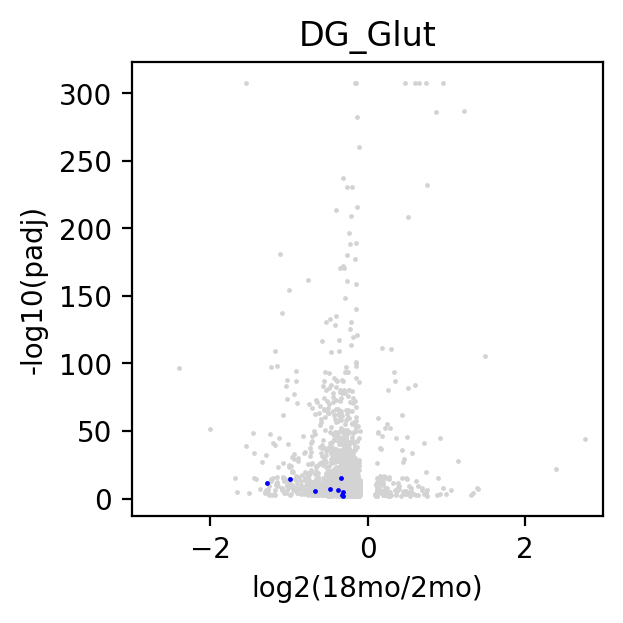

In [18]:
ncols = 1
nrows = 1

fig, ax = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True)

sns.scatterplot(data = deg_result,
                    linewidth = 0,
                    ax = ax,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'blue',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

sns.scatterplot(data = overlap_deg_result[overlap_deg_result['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'red',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
ax.set_title(ct)
ax.set(xlim = (-3,3))

# top_genes = overlap_deg_result[(overlap_deg_result['abs_log2(18mo/2mo)'] > 0.5)]
# top_genes = top_genes.sort_values('fdr').head(10)
# for _, row in top_genes.iterrows():
#     ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
#                 textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)


In [19]:
overlap_deg_result.to_csv('DiffExpress.BoundaryGene.csv')